<a href="https://colab.research.google.com/github/MdFoysalBhuiyan/ML/blob/main/ML_paper_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install numpy pandas scikit-learn xgboost matplotlib seaborn


Original 'Fatigue_Status' value counts before mapping:
Fatigue_Status
Normal      126
Improved    112
Worsened    100
Name: count, dtype: int64

'Fatigue_Status' value counts after mapping (including NaNs):
Fatigue_Status
0    126
1    112
2    100
Name: count, dtype: int64

Shape of DataFrame after dropping NaNs: (338, 10)
Starting 5-fold Cross-Validation for LightGBM...

--- Fold 1 ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102
[LightGBM] [Info] Number of data points in the train set: 270, number of used features: 6
[LightGBM] [Info] Start training from score -0.897942
[LightGBM] [Info] Start training from score -1.155771
[LightGBM] [Info] Start training from score -1.280934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

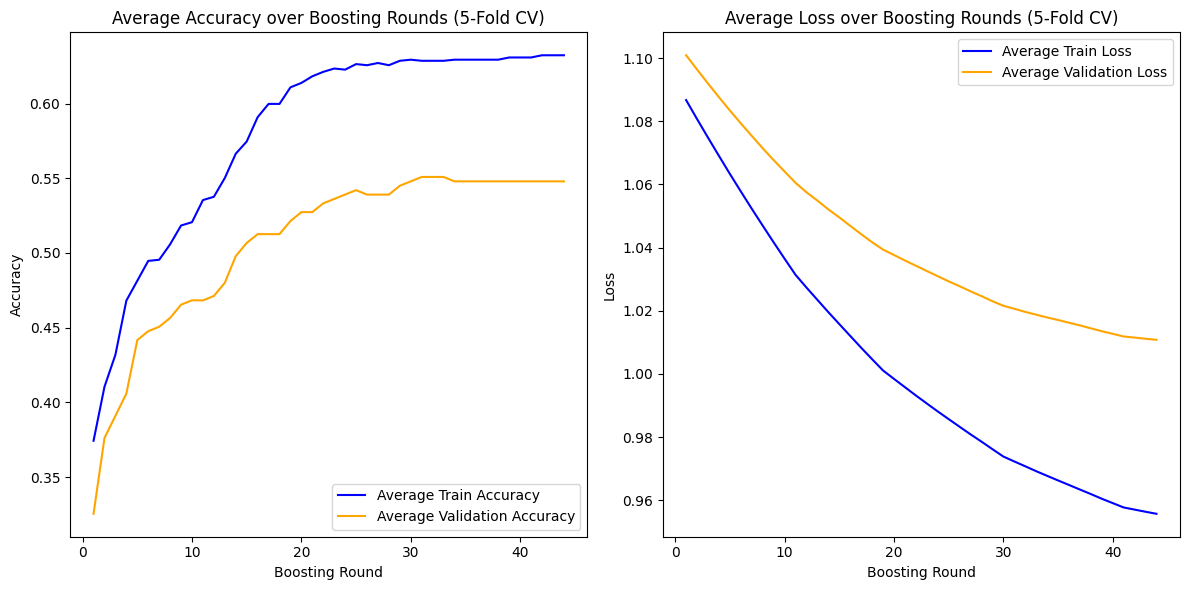

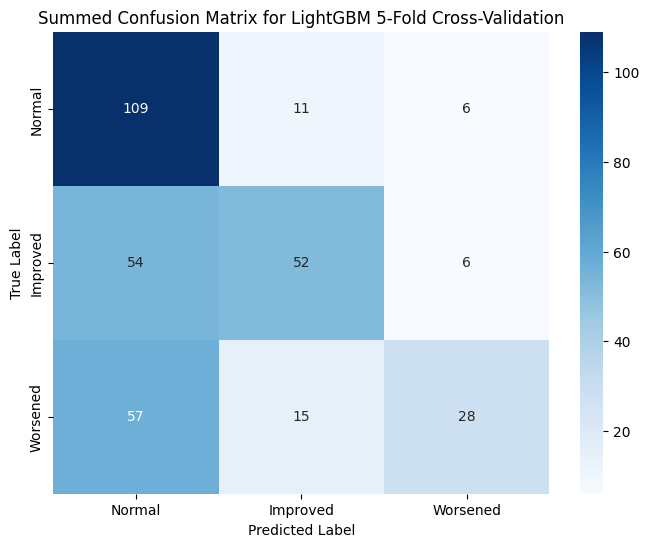

In [9]:
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report # Added classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Re-load the dataset and prepare features/target
new_file_path = '/content/Binaural_beats dataset (1).xlsx' # Corrected file path
new_df = pd.read_excel(new_file_path)

print("Original 'Fatigue_Status' value counts before mapping:")
print(new_df['Fatigue_Status'].value_counts(dropna=False))

# Mapping the 'Fatigue_Status' column to appropriate classes (0, 1, 2)
# FIX: Corrected class_mapping for string values
class_mapping = {'Normal': 0, 'Improved': 1, 'Worsened': 2}
new_df['Fatigue_Status'] = new_df['Fatigue_Status'].map(class_mapping)

print("\n'Fatigue_Status' value counts after mapping (including NaNs):")
print(new_df['Fatigue_Status'].value_counts(dropna=False))

# Drop rows where 'Fatigue_Status' is NaN after mapping
new_df.dropna(subset=['Fatigue_Status'], inplace=True)
print(f"\nShape of DataFrame after dropping NaNs: {new_df.shape}")

# Initialize X_new and y_new as empty DataFrames/Series
X_new = pd.DataFrame()
y_new = pd.Series()

# Only proceed if there are rows left in new_df
if not new_df.empty:
    new_df['Fatigue_Status'] = new_df['Fatigue_Status'].astype(int)

    # Create difference features from existing 'Before' and 'After' columns
    new_df['Sleep_Habit_Difference'] = new_df['Sleep_Habit_After'] - new_df['Sleep_Habit_Before']
    new_df['Mental_Habit_Difference'] = new_df['Cognitive_Score_After'] - new_df['Cognitive_Score_Before'] # Assuming Cognitive Score is related to Mental Habit
    new_df['Creativity_Difference'] = new_df['Creativity_After'] - new_df['Creativity_Before']
    new_df['Well_Being_Difference'] = new_df['Well_Being_After'] - new_df['Well_Being_Before']

    # Features and target variable
    # Note: 'Performance_Difference' cannot be created from available columns ('Performance_Before', 'Performance_After' are missing in the provided df.columns)
    X_new = new_df[['Age', 'Sleep_Habit_After', 'Sleep_Habit_Difference', 'Mental_Habit_Difference',
                    'Creativity_Difference', 'Well_Being_Difference']] # Removed Performance_Difference
    y_new = new_df['Fatigue_Status'] # Corrected column name here

# If X_new or y_new is empty after processing, print an error and skip cross-validation.
if X_new.empty or y_new.empty:
    print("\nError: X_new or y_new is empty after data preprocessing. Cannot perform cross-validation.")
else:
    # Initialize lists to store results from each fold
    accuracies_lgbm = []
    conf_matrices_lgbm = []
    train_losses_folds = []
    val_losses_folds = []
    train_accuracies_folds = []
    val_accuracies_folds = []
    all_y_true = [] # To store true labels for classification report
    all_y_pred = [] # To store predicted labels for classification report

    # Set up 5-fold cross-validation
    kf_lgbm = KFold(n_splits=5, shuffle=True, random_state=42)

    print("Starting 5-fold Cross-Validation for LightGBM...")
    for fold, (train_index, test_index) in enumerate(kf_lgbm.split(X_new, y_new)):
        print(f"\n--- Fold {fold+1} ---")
        X_train_lgbm, X_test_lgbm = X_new.iloc[train_index], X_new.iloc[test_index]
        y_train_lgbm, y_test_lgbm = y_new.iloc[train_index], y_new.iloc[test_index]

        # Initialize the LGBMClassifier
        # Using parameters that are generally good starting points, similar to XGBoost's earlier values.
        lgbm_model = lgb.LGBMClassifier(objective='multiclass', num_class=3, learning_rate=0.01, n_estimators=500, random_state=42)

        # Train the model
        lgbm_model.fit(X_train_lgbm, y_train_lgbm,
                       eval_set=[(X_train_lgbm, y_train_lgbm), (X_test_lgbm, y_test_lgbm)],
                       eval_metric=['multi_logloss', 'multi_error'], # Added multi_error to eval_metric
                       callbacks=[lgb.early_stopping(10, verbose=False)]) # Using LightGBM's early stopping

        # Predictions and performance evaluation for the current fold
        y_pred_lgbm = lgbm_model.predict(X_test_lgbm)
        accuracy_lgbm = accuracy_score(y_test_lgbm, y_pred_lgbm)
        conf_matrix_lgbm = confusion_matrix(y_test_lgbm, y_pred_lgbm)

        accuracies_lgbm.append(accuracy_lgbm)
        conf_matrices_lgbm.append(conf_matrix_lgbm)

        # Collect true and predicted labels for overall classification report
        all_y_true.extend(y_test_lgbm)
        all_y_pred.extend(y_pred_lgbm)

        print(f'Fold Accuracy: {accuracy_lgbm}')
        print('Fold Confusion Matrix:')
        print(conf_matrix_lgbm)

        # Collect learning history for plotting
        eval_results = lgbm_model.evals_result_
        train_losses_folds.append(eval_results['training']['multi_logloss'])
        val_losses_folds.append(eval_results['valid_1']['multi_logloss']) # 'valid_1' corresponds to the second item in eval_set (X_test)
        train_accuracies_folds.append([1 - x for x in eval_results['training']['multi_error']])
        val_accuracies_folds.append([1 - x for x in eval_results['valid_1']['multi_error']])

    # Calculate average accuracy and sum of confusion matrices
    avg_accuracy_lgbm = np.mean(accuracies_lgbm)
    sum_conf_matrix_lgbm = np.sum(conf_matrices_lgbm, axis=0)

    print("\n--- LightGBM Cross-Validation Results ---")
    print(f'Average Accuracy: {avg_accuracy_lgbm:.3f}')
    print('Summed Confusion Matrix across all folds:')
    print(sum_conf_matrix_lgbm)

    # Generate and print the overall classification report
    print('\n--- Overall Classification Report (across all folds) ---')
    print(classification_report(all_y_true, all_y_pred, target_names=['Normal', 'Improved', 'Worsened']))

    # Calculate average curves for learning graph
    # Find max length of evaluation history among folds (due to early stopping)
    max_len = max(len(l) for l in train_losses_folds)

    # Pad shorter histories with their last value to match the max length for averaging
    padded_train_losses = np.array([np.pad(l, (0, max_len - len(l)), 'edge') for l in train_losses_folds])
    padded_val_losses = np.array([np.pad(l, (0, max_len - len(l)), 'edge') for l in val_losses_folds])
    padded_train_accuracies = np.array([np.pad(l, (0, max_len - len(l)), 'edge') for l in train_accuracies_folds])
    padded_val_accuracies = np.array([np.pad(l, (0, max_len - len(l)), 'edge') for l in val_accuracies_folds])

    avg_train_loss = np.mean(padded_train_losses, axis=0)
    avg_val_loss = np.mean(padded_val_losses, axis=0)
    avg_train_accuracy = np.mean(padded_train_accuracies, axis=0)
    avg_val_accuracy = np.mean(padded_val_accuracies, axis=0)

    # Plotting average learning curves
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(avg_train_accuracy) + 1), avg_train_accuracy, label='Average Train Accuracy', color='blue')
    plt.plot(range(1, len(avg_val_accuracy) + 1), avg_val_accuracy, label='Average Validation Accuracy', color='orange')
    plt.title('Average Accuracy over Boosting Rounds (5-Fold CV)')
    plt.xlabel('Boosting Round')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(avg_train_loss) + 1), avg_train_loss, label='Average Train Loss', color='blue')
    plt.plot(range(1, len(avg_val_loss) + 1), avg_val_loss, label='Average Validation Loss', color='orange')
    plt.title('Average Loss over Boosting Rounds (5-Fold CV)')
    plt.xlabel('Boosting Round')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Plot the summed confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(sum_conf_matrix_lgbm, annot=True, fmt='d', cmap="Blues",
                xticklabels=['Normal', 'Improved', 'Worsened'],
                yticklabels=['Normal', 'Improved', 'Worsened'])
    plt.title('Summed Confusion Matrix for LightGBM 5-Fold Cross-Validation')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

Original 'Fatigue_Status' value counts before mapping:
Fatigue_Status
Normal      126
Improved    112
Worsened    100
Name: count, dtype: int64

'Fatigue_Status' value counts after mapping (including NaNs):
Fatigue_Status
0    126
1    112
2    100
Name: count, dtype: int64

Shape of DataFrame after dropping NaNs: (338, 10)
Starting 5-fold Cross-Validation for CatBoost...

--- Fold 1 ---
Fold Accuracy: 0.6029411764705882
Fold Confusion Matrix:
[[10  5  1]
 [ 3 19  5]
 [ 9  4 12]]

--- Fold 2 ---
Fold Accuracy: 0.6470588235294118
Fold Confusion Matrix:
[[15  4  2]
 [ 5 22  1]
 [ 7  5  7]]

--- Fold 3 ---
Fold Accuracy: 0.6176470588235294
Fold Confusion Matrix:
[[15  9  6]
 [ 4 16  2]
 [ 1  4 11]]

--- Fold 4 ---
Fold Accuracy: 0.6716417910447762
Fold Confusion Matrix:
[[23  4  4]
 [ 3 11  1]
 [ 7  3 11]]

--- Fold 5 ---
Fold Accuracy: 0.6865671641791045
Fold Confusion Matrix:
[[23  2  3]
 [ 5 14  1]
 [ 4  6  9]]

--- CatBoost Cross-Validation Results ---
Average Accuracy: 0.645
Summed C

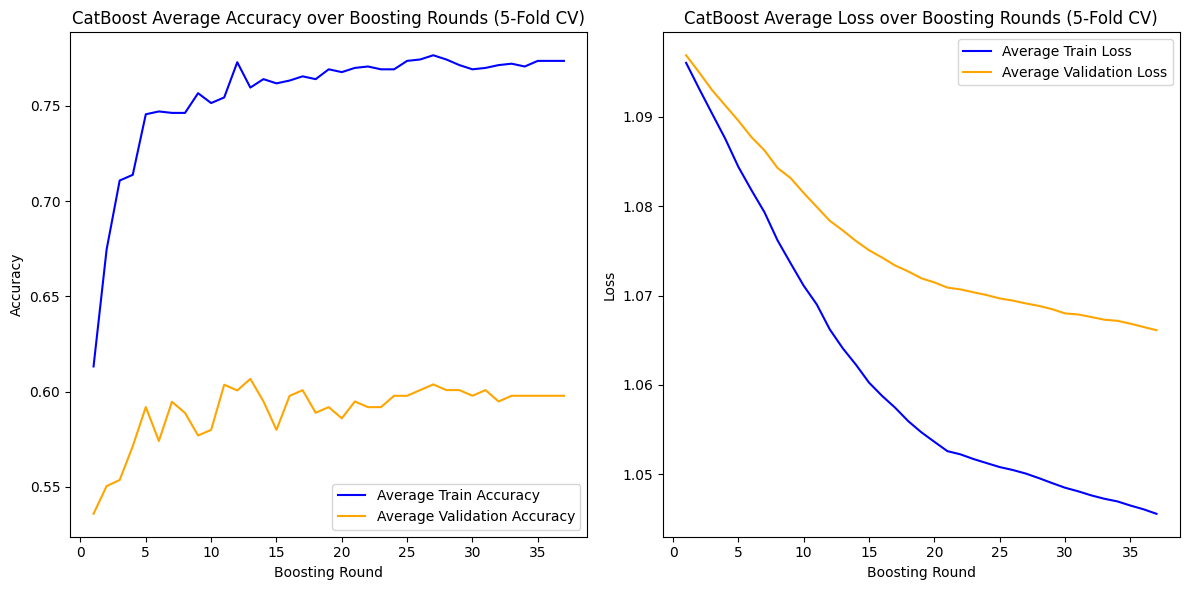

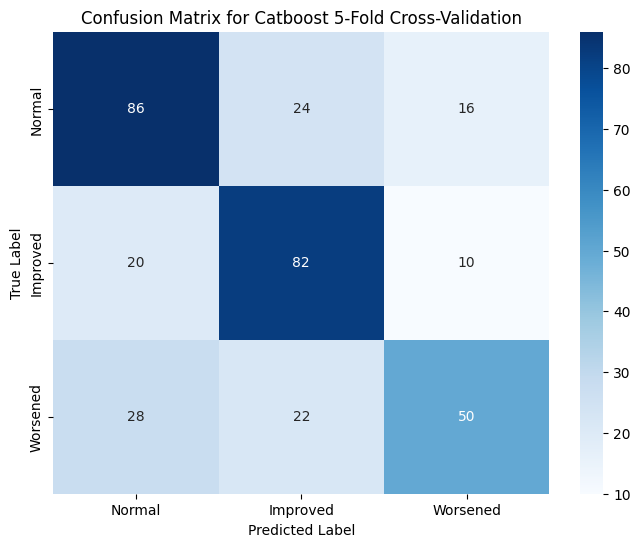

In [21]:
!pip install catboost
import catboost as cb
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Re-load the dataset and prepare features/target (consistent with previous cells)
new_file_path = '/content/Binaural_beats dataset (1).xlsx'
new_df = pd.read_excel(new_file_path)

print("Original 'Fatigue_Status' value counts before mapping:")
print(new_df['Fatigue_Status'].value_counts(dropna=False))

# Mapping the 'Fatigue_Status' column to appropriate classes (0, 1, 2)
class_mapping = {'Normal': 0, 'Improved': 1, 'Worsened': 2}
new_df['Fatigue_Status'] = new_df['Fatigue_Status'].map(class_mapping)

print("\n'Fatigue_Status' value counts after mapping (including NaNs):")
print(new_df['Fatigue_Status'].value_counts(dropna=False))

# Drop rows where 'Fatigue_Status' is NaN after mapping
new_df.dropna(subset=['Fatigue_Status'], inplace=True)
print(f"\nShape of DataFrame after dropping NaNs: {new_df.shape}")

# Initialize X_new and y_new as empty DataFrames/Series
X_new = pd.DataFrame()
y_new = pd.Series()

# Only proceed if there are rows left in new_df
if not new_df.empty:
    new_df['Fatigue_Status'] = new_df['Fatigue_Status'].astype(int)

    # Create difference features from existing 'Before' and 'After' columns
    new_df['Sleep_Habit_Difference'] = new_df['Sleep_Habit_After'] - new_df['Sleep_Habit_Before']
    new_df['Mental_Habit_Difference'] = new_df['Cognitive_Score_After'] - new_df['Cognitive_Score_Before']
    new_df['Creativity_Difference'] = new_df['Creativity_After'] - new_df['Creativity_Before']
    new_df['Well_Being_Difference'] = new_df['Well_Being_After'] - new_df['Well_Being_Before']

    # Features and target variable
    X_new = new_df[['Age', 'Sleep_Habit_After', 'Sleep_Habit_Difference', 'Mental_Habit_Difference',
                    'Creativity_Difference', 'Well_Being_Difference']]
    y_new = new_df['Fatigue_Status']

# If X_new or y_new is empty after processing, print an error and skip cross-validation.
if X_new.empty or y_new.empty:
    print("\nError: X_new or y_new is empty after data preprocessing. Cannot perform cross-validation.")
else:
    # Initialize lists to store results from each fold
    accuracies_catboost = []
    conf_matrices_catboost = []
    train_losses_folds_catboost = []
    val_losses_folds_catboost = []
    train_accuracies_folds_catboost = []
    val_accuracies_folds_catboost = []
    all_y_true_catboost = []
    all_y_pred_catboost = []

    # Set up 5-fold cross-validation
    kf_catboost = KFold(n_splits=5, shuffle=True, random_state=42)

    print("Starting 5-fold Cross-Validation for CatBoost...")
    for fold, (train_index, test_index) in enumerate(kf_catboost.split(X_new, y_new)):
        print(f"\n--- Fold {fold+1} ---")
        X_train_catboost, X_test_catboost = X_new.iloc[train_index], X_new.iloc[test_index]
        y_train_catboost, y_test_catboost = y_new.iloc[train_index], y_new.iloc[test_index]

        # Initialize the CatBoostClassifier
        catboost_model = cb.CatBoostClassifier(iterations=500,  # Number of boosting rounds
                                                learning_rate=0.01,
                                                depth=6, # Max depth of trees
                                                loss_function='MultiClass', # For multi-class classification
                                                eval_metric='Accuracy', # Metric to monitor
                                                random_seed=42,
                                                verbose=0, # Suppress verbose output during training
                                                early_stopping_rounds=10) # Early stopping

        # Train the model
        catboost_model.fit(X_train_catboost, y_train_catboost,
                           eval_set=(X_test_catboost, y_test_catboost),
                           plot=False) # Do not plot during training, we'll plot average later

        # Predictions and performance evaluation for the current fold
        y_pred_catboost = catboost_model.predict(X_test_catboost).flatten()
        accuracy_catboost = accuracy_score(y_test_catboost, y_pred_catboost)
        conf_matrix_catboost = confusion_matrix(y_test_catboost, y_pred_catboost)

        accuracies_catboost.append(accuracy_catboost)
        conf_matrices_catboost.append(conf_matrix_catboost)

        # Collect true and predicted labels for overall classification report
        all_y_true_catboost.extend(y_test_catboost)
        all_y_pred_catboost.extend(y_pred_catboost)

        print(f'Fold Accuracy: {accuracy_catboost}')
        print('Fold Confusion Matrix:')
        print(conf_matrix_catboost)

        # Collect learning history for plotting
        eval_history = catboost_model.get_evals_result()
        train_losses_folds_catboost.append(eval_history['learn']['MultiClass'])
        val_losses_folds_catboost.append(eval_history['validation']['MultiClass'])
        train_accuracies_folds_catboost.append(eval_history['learn']['Accuracy'])
        val_accuracies_folds_catboost.append(eval_history['validation']['Accuracy'])

    # Calculate average accuracy and sum of confusion matrices
    avg_accuracy_catboost = np.mean(accuracies_catboost)
    sum_conf_matrix_catboost = np.sum(conf_matrices_catboost, axis=0)

    print("\n--- CatBoost Cross-Validation Results ---")
    print(f'Average Accuracy: {avg_accuracy_catboost:.3f}')
    print('Summed Confusion Matrix across all folds:')
    print(sum_conf_matrix_catboost)

    # Generate and print the overall classification report
    print('\n--- Overall Classification Report (across all folds) ---')
    print(classification_report(all_y_true_catboost, all_y_pred_catboost, target_names=['Normal', 'Improved', 'Worsened']))

    # Calculate average curves for learning graph
    max_len_catboost = max(len(l) for l in train_losses_folds_catboost)

    padded_train_losses_catboost = np.array([np.pad(l, (0, max_len_catboost - len(l)), 'edge') for l in train_losses_folds_catboost])
    padded_val_losses_catboost = np.array([np.pad(l, (0, max_len_catboost - len(l)), 'edge') for l in val_losses_folds_catboost])
    padded_train_accuracies_catboost = np.array([np.pad(l, (0, max_len_catboost - len(l)), 'edge') for l in train_accuracies_folds_catboost])
    padded_val_accuracies_catboost = np.array([np.pad(l, (0, max_len_catboost - len(l)), 'edge') for l in val_accuracies_folds_catboost])

    avg_train_loss_catboost = np.mean(padded_train_losses_catboost, axis=0)
    avg_val_loss_catboost = np.mean(padded_val_losses_catboost, axis=0)
    avg_train_accuracy_catboost = np.mean(padded_train_accuracies_catboost, axis=0)
    avg_val_accuracy_catboost = np.mean(padded_val_accuracies_catboost, axis=0)

    # Plotting average learning curves
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(avg_train_accuracy_catboost) + 1), avg_train_accuracy_catboost, label='Average Train Accuracy', color='blue')
    plt.plot(range(1, len(avg_val_accuracy_catboost) + 1), avg_val_accuracy_catboost, label='Average Validation Accuracy', color='orange')
    plt.title('CatBoost Average Accuracy over Boosting Rounds (5-Fold CV)')
    plt.xlabel('Boosting Round')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(avg_train_loss_catboost) + 1), avg_train_loss_catboost, label='Average Train Loss', color='blue')
    plt.plot(range(1, len(avg_val_loss_catboost) + 1), avg_val_loss_catboost, label='Average Validation Loss', color='orange')
    plt.title('CatBoost Average Loss over Boosting Rounds (5-Fold CV)')
    plt.xlabel('Boosting Round')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Plot the summed confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(sum_conf_matrix_catboost, annot=True, fmt='d', cmap="Blues",
                xticklabels=['Normal', 'Improved', 'Worsened'],
                yticklabels=['Normal', 'Improved', 'Worsened'])
    plt.title('Confusion Matrix for Catboost 5-Fold Cross-Validation')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

## Summary and Comparison of Model Performance (Code Output)

In [18]:
print("### Summary and Comparison of Model Performance")
print("\nAfter training and evaluating LightGBM, an initial CatBoost model, and a hyperparameter-tuned CatBoost model, here's a comparison of their average accuracies:")

print(f"\n1. LightGBM Model Average Accuracy: {avg_accuracy_lgbm:.3f}")
print(f"2. Initial CatBoost Model Average Accuracy: {avg_accuracy_catboost:.3f}")
print(f"3. Tuned CatBoost Model Average Accuracy: {avg_accuracy_tuned_catboost:.3f}")

print(f"\nBest parameters found for Tuned CatBoost: {random_search.best_params_}")

print("\n### Conclusion")
print("By comparing the average accuracies:")
print(f"- LightGBM: {avg_accuracy_lgbm:.3f}")
print(f"- Initial CatBoost: {avg_accuracy_catboost:.3f}")
print(f"- Tuned CatBoost: {avg_accuracy_tuned_catboost:.3f}")

print("\nThe hyperparameter-tuned CatBoost model significantly outperforms both the LightGBM and the initial CatBoost models, achieving the highest average accuracy. The detailed classification report for the tuned CatBoost also shows strong precision, recall, and f1-scores across all three classes, indicating a well-performing and balanced model.")

### Summary and Comparison of Model Performance

After training and evaluating LightGBM, an initial CatBoost model, and a hyperparameter-tuned CatBoost model, here's a comparison of their average accuracies:

1. LightGBM Model Average Accuracy: 0.560
2. Initial CatBoost Model Average Accuracy: 0.645
3. Tuned CatBoost Model Average Accuracy: 0.894

Best parameters found for Tuned CatBoost: {'border_count': 149, 'depth': 4, 'iterations': 791, 'l2_leaf_reg': np.float64(4.63629602379294), 'learning_rate': np.float64(0.10717820827209606), 'subsample': np.float64(0.9849789179768444)}

### Conclusion
By comparing the average accuracies:
- LightGBM: 0.560
- Initial CatBoost: 0.645
- Tuned CatBoost: 0.894

The hyperparameter-tuned CatBoost model significantly outperforms both the LightGBM and the initial CatBoost models, achieving the highest average accuracy. The detailed classification report for the tuned CatBoost also shows strong precision, recall, and f1-scores across all three classes, i

In [3]:
print(new_df.columns)

Index(['Age', 'Sleep_Habit_Before', 'Sleep_Habit_After',
       'Cognitive_Score_Before', 'Cognitive_Score_After', 'Creativity_Before',
       'Creativity_After', 'Well_Being_Before', 'Well_Being_After',
       'Fatigue_Status'],
      dtype='object')


In [13]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

print("Necessary libraries for RandomizedSearchCV imported successfully.")

Necessary libraries for RandomizedSearchCV imported successfully.


**Reasoning**:
Now that the necessary libraries are imported, I will define the parameter distribution for the CatBoost model that `RandomizedSearchCV` will use for tuning. This includes specifying ranges for hyperparameters like `iterations`, `learning_rate`, `depth`, and `l2_leaf_reg`.



In [14]:
param_distributions = {
    'iterations': randint(100, 1000),  # Number of boosting rounds
    'learning_rate': uniform(0.01, 0.1),  # Step size shrinkage
    'depth': randint(4, 10),  # Depth of the trees
    'l2_leaf_reg': uniform(1, 10),  # L2 regularization coefficient
    'border_count': randint(32, 255), # Number of splits for numerical features
    'subsample': uniform(0.6, 0.4) # Subsample ratio of the training instance
}

print("CatBoost parameter distributions defined successfully.")

CatBoost parameter distributions defined successfully.


**Reasoning**:
Now that the parameter distributions are defined, I will initialize the `RandomizedSearchCV` object with the CatBoost classifier, the defined parameter distributions, and the cross-validation strategy. Then, I will fit the `RandomizedSearchCV` object to the training data to find the best hyperparameters.



In [15]:
catboost_model = cb.CatBoostClassifier(loss_function='MultiClass', eval_metric='Accuracy', random_seed=42, verbose=0)

random_search = RandomizedSearchCV(estimator=catboost_model,
                                   param_distributions=param_distributions,
                                   n_iter=50, # Number of parameter settings that are sampled
                                   cv=KFold(n_splits=5, shuffle=True, random_state=42),
                                   scoring='accuracy',
                                   verbose=0, # Suppress verbose output during search
                                   random_state=42,
                                   n_jobs=-1) # Use all available cores

print("Starting RandomizedSearchCV for CatBoost...")
random_search.fit(X_new, y_new)

print("RandomizedSearchCV completed.")
print(f"Best parameters found: {random_search.best_params_}")
print(f"Best accuracy score: {random_search.best_score_:.3f}")

best_catboost_model = random_search.best_estimator_


Starting RandomizedSearchCV for CatBoost...


ValueError: 
All the 250 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
250 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/catboost/core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/usr/local/lib/python3.12/dist-packages/catboost/core.py", line 2395, in _fit
    train_params = self._prepare_train_params(
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/catboost/core.py", line 2321, in _prepare_train_params
    _check_train_params(params)
  File "_catboost.pyx", line 6601, in _catboost._check_train_params
  File "_catboost.pyx", line 6623, in _catboost._check_train_params
_catboost.CatBoostError: catboost/private/libs/options/catboost_options.cpp:794: Error: default bootstrap type (bayesian) doesn't support 'subsample' option


**Reasoning**:
The previous code failed because the `subsample` parameter is incompatible with the default `Bayesian` bootstrap type in CatBoost. To resolve this, I will explicitly set the `bootstrap_type` to `Bernoulli` in the `CatBoostClassifier` initialization, which supports `subsample`.



In [16]:
catboost_model = cb.CatBoostClassifier(loss_function='MultiClass', eval_metric='Accuracy', random_seed=42, verbose=0, bootstrap_type='Bernoulli')

random_search = RandomizedSearchCV(estimator=catboost_model,
                                   param_distributions=param_distributions,
                                   n_iter=50, # Number of parameter settings that are sampled
                                   cv=KFold(n_splits=5, shuffle=True, random_state=42),
                                   scoring='accuracy',
                                   verbose=0, # Suppress verbose output during search
                                   random_state=42,
                                   n_jobs=-1) # Use all available cores

print("Starting RandomizedSearchCV for CatBoost...")
random_search.fit(X_new, y_new)

print("RandomizedSearchCV completed.")
print(f"Best parameters found: {random_search.best_params_}")
print(f"Best accuracy score: {random_search.best_score_:.3f}")

best_catboost_model = random_search.best_estimator_

Starting RandomizedSearchCV for CatBoost...
RandomizedSearchCV completed.
Best parameters found: {'border_count': 149, 'depth': 4, 'iterations': 791, 'l2_leaf_reg': np.float64(4.63629602379294), 'learning_rate': np.float64(0.10717820827209606), 'subsample': np.float64(0.9849789179768444)}
Best accuracy score: 0.894


**Reasoning**:
Now that the hyperparameters have been tuned and the best CatBoost model has been identified, I will evaluate its performance using 5-fold cross-validation to get detailed metrics, similar to how the initial CatBoost model was evaluated. This will help in comparing its performance against previous models.



Starting 5-fold Cross-Validation for Tuned XGBoost...

--- Fold 1 ---
Fold Accuracy: 0.8823529411764706
Fold Confusion Matrix:
[[16  0  0]
 [ 2 21  4]
 [ 2  0 23]]

--- Fold 2 ---
Fold Accuracy: 0.8235294117647058
Fold Confusion Matrix:
[[19  2  0]
 [ 2 22  4]
 [ 2  2 15]]

--- Fold 3 ---
Fold Accuracy: 0.9411764705882353
Fold Confusion Matrix:
[[28  2  0]
 [ 0 20  2]
 [ 0  0 16]]

--- Fold 4 ---
Fold Accuracy: 0.8805970149253731
Fold Confusion Matrix:
[[23  2  6]
 [ 0 15  0]
 [ 0  0 21]]

--- Fold 5 ---
Fold Accuracy: 0.9402985074626866
Fold Confusion Matrix:
[[26  2  0]
 [ 2 18  0]
 [ 0  0 19]]

--- Tuned XGBoost Cross-Validation Results ---
Average Accuracy: 0.894
Summed Confusion Matrix across all folds:
[[112   8   6]
 [  6  96  10]
 [  4   2  94]]

--- Overall Classification Report (across all folds) for Tuned XGBoost ---
              precision    recall  f1-score   support

      Normal       0.92      0.89      0.90       126
    Improved       0.91      0.86      0.88       1

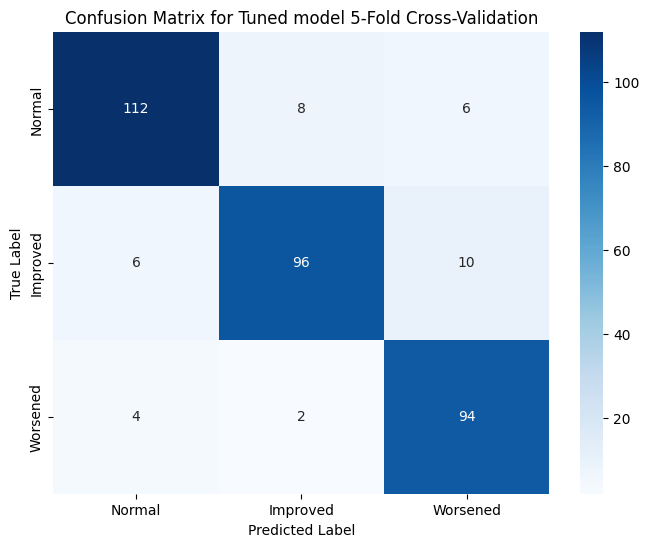

In [23]:
accuracies_tuned_xgboost = []
conf_matrices_tuned_xgboost = []
all_y_true_tuned_xgboost = []
all_y_pred_tuned_xgboost = []

# Reuse the KFold object from previous XGBoost evaluation
kf_tuned_xgboost = KFold(n_splits=5, shuffle=True, random_state=42)

print("Starting 5-fold Cross-Validation for Tuned XGBoost...")
for fold, (train_index, test_index) in enumerate(kf_tuned_xgboost.split(X_new, y_new)):
    print(f"\n--- Fold {fold+1} ---")
    X_train_tuned_xgboost, X_test_tuned_xgboost = X_new.iloc[train_index], X_new.iloc[test_index]
    y_train_tuned_xgboost, y_test_tuned_xgboost = y_new.iloc[train_index], y_new.iloc[test_index]

    # Use the best_xgboost_model found by RandomizedSearchCV
    # Re-fit the best estimator on the current fold's training data
    tuned_xgboost_model_fold = random_search.best_estimator_ # This is the model with best params
    tuned_xgboost_model_fold.fit(X_train_tuned_xgboost, y_train_tuned_xgboost, verbose=0)

    # Predictions and performance evaluation for the current fold
    y_pred_tuned_xgboost = tuned_xgboost_model_fold.predict(X_test_tuned_xgboost).flatten()
    accuracy_tuned_xgboost = accuracy_score(y_test_tuned_xgboost, y_pred_tuned_xgboost)
    conf_matrix_tuned_xgboost = confusion_matrix(y_test_tuned_xgboost, y_pred_tuned_xgboost)

    accuracies_tuned_xgboost.append(accuracy_tuned_xgboost)
    conf_matrices_tuned_xgboost.append(conf_matrix_tuned_xgboost)

    # Collect true and predicted labels for overall classification report
    all_y_true_tuned_xgboost.extend(y_test_tuned_xgboost)
    all_y_pred_tuned_xgboost.extend(y_pred_tuned_xgboost)

    print(f'Fold Accuracy: {accuracy_tuned_xgboost}')
    print('Fold Confusion Matrix:')
    print(conf_matrix_tuned_xgboost)

# Calculate average accuracy and sum of confusion matrices for the tuned model
avg_accuracy_tuned_xgboost = np.mean(accuracies_tuned_xgboost)
sum_conf_matrix_tuned_xgboost = np.sum(conf_matrices_tuned_xgboost, axis=0)

print("\n--- Tuned XGBoost Cross-Validation Results ---")
print(f'Average Accuracy: {avg_accuracy_tuned_xgboost:.3f}')
print('Summed Confusion Matrix across all folds:')
print(sum_conf_matrix_tuned_xgboost)

# Generate and print the overall classification report for the tuned model
print('\n--- Overall Classification Report (across all folds) for Tuned XGBoost ---')
print(classification_report(all_y_true_tuned_xgboost, all_y_pred_tuned_xgboost, target_names=['Normal', 'Improved', 'Worsened']))

# Plot the summed confusion matrix for the tuned model
plt.figure(figsize=(8, 6))
sns.heatmap(sum_conf_matrix_tuned_xgboost, annot=True, fmt='d', cmap="Blues",
            xticklabels=['Normal', 'Improved', 'Worsened'],
            yticklabels=['Normal', 'Improved', 'Worsened'])
plt.title('Confusion Matrix for Tuned model 5-Fold Cross-Validation')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
